## P300 Speller 실험 데이터를 기반으로 ERP(Event-Related Potential) 신호를 전처리하고 시각화 진행
- 단일 피험자 ERP 확인
    - midline 적극(Fz, Cz, Pz)에서 target/non-target 자극에 대한 ERP 시각화
    - grand-average ERP 계산: 55명의 피험자 데이터를 평균내어 전체적인 경향 확인
    - ERP peak 측정: 각 피험자의 P300 peak amplitude와 latency 저장
    - ERP 시각화: 평균 ERP 곡선과 시간별 topoplot을 통해 시공간적 패턴 시각화

#### P300Speller Visualization ver1


In [ ]:
% P300Speller Visualization ver1
%
% Kyungho Won
%
% [ reference ]
% data: BCI2000, 32 Biosemi2, 55 subjects
% target text: BRAIN, POWER / SUBJECT, NEURONS, IMAGINE, QUALITY
% target : standard = 30 : 150
%
% [ Stage ]
%  1. Pre-processing: bandpass filtering, extracting triggers
%     - freq = [0.5 40]
%     - frame = [0 1000]
%     - baseline = [-200 0]

In [ ]:
clear; clc;
ch = 1:32; % select channels

# ERP 분석에 사용할 파라미터 설정
Params_P3speller = struct('freq', [1 10], ...   # Bandpass filter 주파수
                        'frame', [0 1000], ...  # epoch 범위(ms)
                        'baseline', [-200 0], ...   # baseline 보정 구간
                        'select_ch', 1:32); # 선택 채널

# 주의 깊게 보는 중앙 전극
electrodes_midline = {'FZ', 'Cz', 'Pz'};

# 안구 움직임 전극 (노이즈 참고용)
electrodes_eyes = {'FP1', 'FP2', 'AF3', 'AF4'};

# ======================== 개별 피험자 ERP 시각화  (1명만) ========================  #
for nsb=1

    # 피험자 nsb번의 EEG 파일 로드
    fname_train = sprintf('../data/P300spellerdataset/s%02d.mat', nsb);
    EEG = load(fname_train);
    eeg_test = EEG.test;    # 테스트 세션 EEG 데이터
    
    % ------------------------ CALIBRATION EEG ------------------------- %
    eeg_target = [];    # target 자극에 대한 epoch 저장용
    eeg_nontarget = []; # non-target 자극에 대한 epoch 저장용

    # 각 run에 대해 target / non-target epoch 추출
    for nRun = 1:length(eeg_test)
        cur_eeg = eeg_test{nRun};

        # 관심 채널 인덱스 (Fz, Cz, Pz)
        interest_ch = ismember({cur_eeg.chanlocs.labels}, electrodes_midline);
        
        # target / non-target epoch 추출 (사용자 정의 함수)
        [cur_target, cur_nontarget] = preproc_extractEpoch(cur_eeg, Params_P3speller);
        
        # epoch을 3차원 형태로 누적 저장 (채널 x 시간 x trial)
        eeg_target = cat(3, eeg_target, cur_target);
        eeg_nontarget = cat(3, eeg_nontarget, cur_nontarget);
    end
    
    figure,

    # 시간 벡터 생성 (baseline 포함한 epoch 구간)
    t = linspace(Params_P3speller.baseline(1), Params_P3speller.frame(2), size(cur_target, 2));
    
    # 평균 ERP 계산 (각 채널별)
    avg_target = mean(eeg_target, 3)';
    avg_nontarget = mean(eeg_nontarget, 3)';
    
    # 표준편차 계산
    std_target = std(cur_target, [], 3)';
    std_nontarget = std(cur_nontarget, [], 3)';

    # ERP 시각화 (선 그래프 + 그림자)
    vis_ERP(t, mean(avg_target(:, interest_ch),2), mean(avg_nontarget(:, interest_ch),2), ...
        Params_P3speller.baseline, 0:200:1000, std_target(:, interest_ch), std_nontarget(:, interest_ch), 'off');
    
%     topo3D = cat(3, avg_target', avg_nontarget', (avg_target-avg_nontarget)');
%     clim = [-3 3];
%     frames = 0:200:1200;
%     figure,
%     vis_temporalTopoplot(topo3D, cur_eeg.srate, frames, cur_eeg.chanlocs, clim);
%     colormap(redblue);
end


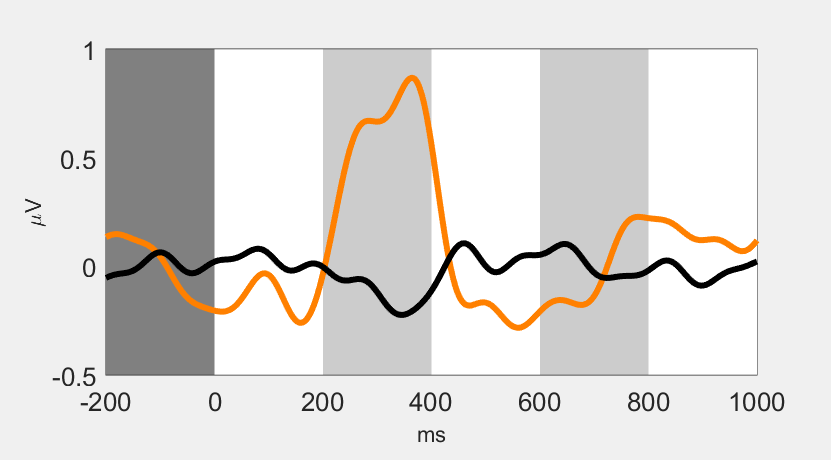

[그래프 분석]: 해당 피험자 1명의 target vs non-target ERP 반응만을 평균낸 결과
- 해당 피험자 1명의 target vs non-target ERP 반응만을 평균낸 결과
- P300이 선명하게 나타나지만, 개인의 노이즈나 특성에 영향을 많이 받음
- P300 반응 특징
    - 주황색 선(target)이 300~400ms 사이에 뚜렷한 양의 파형(peak) 형성 -> P300 컴포넌트
    - 이는 P300 ERP의 전형적인 시간대와 방향성을 따름
    - peak amplitude는 약 0.9
- Non-target 반응
    - 검은 선은 큰 변화 없이 baseline에 가까운 값 유지
    - 이는 non-target 자극에 대해 뚜렷한 주의 집중 반응이 없음 의미
- ERP의 시간 분포
    - 주된 target vs non-target 차이는 300~500ms 구간에서 관찰
    - 그 외 시간대에서는 두 곡선이 거의 일치 -> target 반응이 시간적으로 제한되어 있음 시사

In [ ]:
%% grand-averaged

clear; clc;
ch = 1:32; % select channels
nbsub = 55;

Params_P3speller = struct('freq', [1 10], 'frame', [0 1000], ...
    'baseline', [-200 0], 'select_ch', 1:32);
electrodes_midline = {'FZ', 'Cz', 'Pz'};

grand_target = [];
grand_nontarget =[];

# 각 피험자 데이터 반복 처리
for nsb=1:nbsub
    fname = sprintf('../data/P300spellerdataset/s%02d.mat', nsb);
    EEG = load(fname);
    fprintf('Loading %s..\n', fname);
    eeg_test = EEG.test;
    
    % ------------------------ CALIBRATION EEG ------------------------- %
    eeg_target = [];
    eeg_nontarget = [];

    for nRun = 1:length(eeg_test)
        cur_eeg = eeg_test{nRun};
        interest_ch = ismember({cur_eeg.chanlocs.labels}, electrodes_midline);
        [cur_target, cur_nontarget] = preproc_extractEpoch(cur_eeg, Params_P3speller);
        
        eeg_target = cat(3, eeg_target, cur_target);
        eeg_nontarget = cat(3, eeg_nontarget, cur_nontarget);
    end
    
    # P300 peak amplotude 및 Latency 측정
    % individual peak amplitude and latency
    [ERP_amp(nsb), ERP_lat(nsb)] = max(mean(mean(eeg_target(interest_ch, :, :), 3), 1));
    
    # 평균 ERP를 grand-averaging을 위해 저장
    grand_target = cat(3, grand_target, mean(eeg_target,3));
    grand_nontarget = cat(3, grand_nontarget, mean(eeg_nontarget,3));
end
disp('done');

In [ ]:
%% save - current grand average settings

SpellerERP_grand.target = grand_target;
SpellerERP_grand.nontarget = grand_nontarget;
SpellerERP_grand.cfg = Params_P3speller;
SpellerERP_grand.ch = electrodes_midline;
SpellerERP_grand.ERP_amp = ERP_amp;
SpellerERP_grand.ERP_lat = ERP_lat;
SpellerERP_grand.t = linspace(Params_P3speller.baseline(1), Params_P3speller.frame(2), size(cur_target, 2));

save('SpellerERP_grand.mat', '-v7.3', '-struct', 'SpellerERP_grand');
disp('done');


In [ ]:
# 저장된 ERP 평균 결과 불러오기
%% load

SpellerERP_grand = load('SpellerERP_grand.mat');


In [ ]:
# Grand Averaging ERP 시각화
%% ERP
Params_P3speller = struct('freq', [1 10], 'frame', [0 1000], ...
    'baseline', [-200 0], 'select_ch', 1:32, 'srate', 512);
electrodes_midline = {'FZ', 'Cz', 'Pz'};
chanlocs = importdata('biosemi32_locs.mat'); # 채널 위치 정보 불러오기
interest_ch = ismember({chanlocs.labels}, electrodes_midline);

figure,
t = linspace(Params_P3speller.baseline(1), Params_P3speller.frame(2), size(SpellerERP_grand.target, 2));

# 전체 피험자 평균
avg_target = mean(SpellerERP_grand.target, 3)';
avg_nontarget = mean(SpellerERP_grand.nontarget, 3)';

# 표준편차 계산
std_target = std(SpellerERP_grand.target, [], 3)';
std_nontarget = std(SpellerERP_grand.nontarget, [], 3)';

# 중앙 전극에서 ERP 평균 계산
grand_Target = mean(avg_target(:, interest_ch),2);
grand_Nontarget = mean(avg_nontarget(:, interest_ch),2);

# ERP 시각화
vis_ERP(t, grand_Target, grand_Nontarget, ...
    Params_P3speller.baseline, 0:200:1000, std_target(:, interest_ch), std_nontarget(:, interest_ch), 'off');
yline(0);   # 기준선
legend({'Target', 'Non-target'});


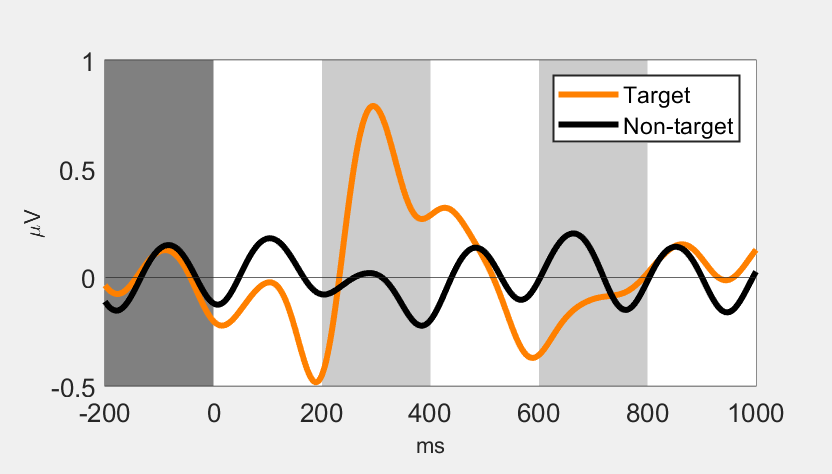

[그래프 분석]: 총 55명 피험자의 데이터를 평균낸 결과
- 모든 피험자의 ERP를 평균내어 보편적인 P300 반응 패턴을 얻은 것
- 잡음이 줄고, ERP의 전형적인 특징(P300 시점, 진폭)이 더 뚜렷해짐
- P300 파형의 식별
    - Target 곡선은 약 300~400ms 사이에서 뚜렷한 양성 피크(P300)를 보임
        - 이는 피험자가 인식한 target 자국에 대해 주의 집중했음을 의미
        - ERP peak는 약 +0.9
    - Non-target은 해당 시간대에 명확한 peak가 없고 baseline 주변에서 진동
- Baseline 구간
    - -200~0ms: baseline correction을 위해 사용
    - 양 곡선 모두 baseline 근처에서 시작하고, 이후 target에만 반응이 나타남
- ERP 시간 경과
    - 주황색 곡선은 자극 후 200~400ms 구간에서 빠르게 상승하고 이후 완만하게 감소
    - Non-target은 전반적으로 플랫하며, stimulus와 관계 없는 작은 진동만 나타남

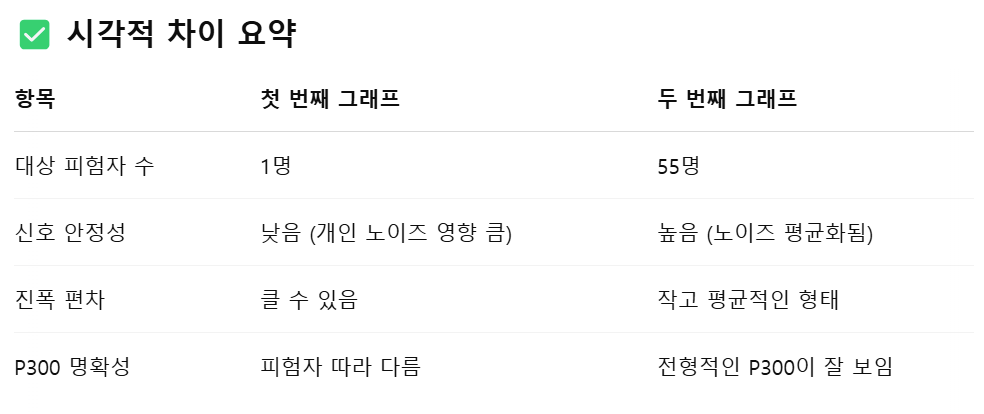

In [ ]:
# 시간별 topoplot 시각화
%% Time topo

topo3D = cat(3, avg_target', avg_nontarget');
clim = [-1 1];
frames = 0:200:1200;
figure,
vis_temporalTopoplot(topo3D, Params_P3speller.srate, frames, chanlocs, clim);
colormap(redblue);

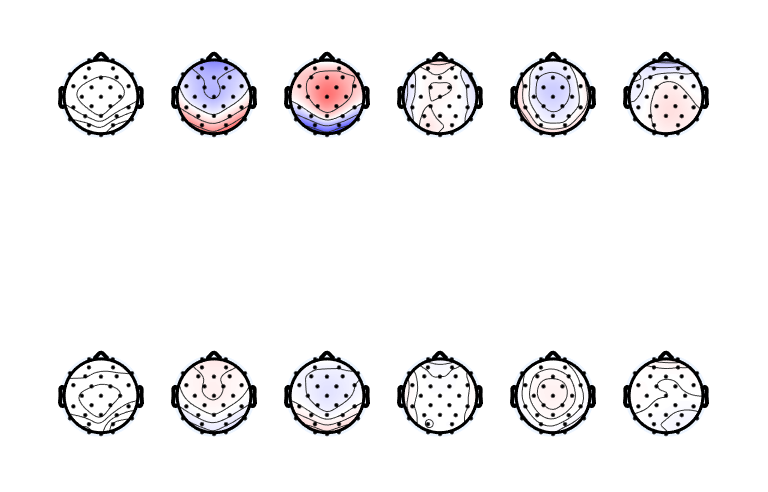

[그래프 분석]: EEG 전극 분포 상에서 시간에 따른 ERP 시각화를 나타낸 Topographic map (Topoplot) 시퀀스
- 시간 흐름에 따라 scalp 위 전압 분포의 변화를 시각적으로 표현한 것
- 1. 시간 순서
    - 왼쪽에서 오른쪽, 위에서 아래로 시간 순서대로 배열되어 있음
    - 일반적으로 200ms ~ 800ms 구간을 100ms 간격으로 시각화하는 경우가 많음
    - 아래와 같은 시간 순서를 가정해볼 수 있음:
        [0, 100, 200, 300, 400, 500]
        [600, 700, 800, 900, 1000, 1100]
- 2. P300의 시공간적 분포
    - 상단 두 번째 또는 세 번째 topoplot에서 중앙부(Pz 인근)에 빨간색 양전위 영역이 뚜렷하게 나타남 → P300 반응
    - 그 직전에는 상대적으로 음전위 영역(파란색)이 존재 → typical N200-P300 반응 흐름
    - 이후에는 전반적으로 평탄해지며 활동이 줄어듦 → 자극 반응 종료
- 3. 전극별 반응
    - 반응은 정수리 부위 (Parietal region)에 국한되어 있음
    - 이는 P300 ERP가 주로 Pz, Cz 주변에서 발생하는 전형적인 분포와 일치함